# PHATE demonstration

Here we demonstrate PHATE, a tool for visualizing high dimensional single-cell data on two datasets. You can run and edit this notebook at https://colab.research.google.com/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/PHATE_tree.ipynb. Running the entire tutorial from start to finish (excluding the MDS/t-SNE comparison) should take approximately three minutes on a laptop computer, or 8 minutes including the comparison.

1. Read [our preprint on BioRxiv](http://biorxiv.org/content/early/2017/03/24/120378)
2. Download [our code on GitHub](https://github.com/KrishnaswamyLab/PHATE)

High-dimensional single-cell data, and biological data in general, often lies on a continuum with trajectory structure. Examples are developmental systems such as embryogenesis.

To visualize high-dimensional data onto a 2 or 3 dimensional embedding we employ dimensionality reduction methods. Examples are PCA, MDS and tSNE. PCA and MDS are good for finding an optimal linear transformation that gives the major axes of variation in the data. However, the underlying data structure is often non-linear in which case PCA is not ideal. tSNE is a method that has recently gained a lot of popularity. tSNE is able to embed non-linear data, however it is optimized for cluster structure and as a result will destroy any continuous progression structure in the data.

To have both non-linear dimensionality reduction and emphasize continuoius structure we developed PHATE: Potential of Heat diffusion Affinity-based Transitional Embedding. PHATE uses a diffusion process to denoise the data and then constructs an energy potential that is then embedded using MDS.

In this tutorial we will setup and run PHATE on a synthetically generated dataset of a random tree.

PHATE consists of the following steps:

1. Compute a distance matrix
2. Convert distances into affinities using a kernel
3. Markov normalize the kernel to get a diffusion operator
4. Raise the operator the the t-th power to diffuse for t steps
5. Take the negative log of the operator to get an energy potential
6. Compute distances and run MDS to get a 2 or 3 dimensional embedding

## Code-through

First things first: if you have not yet installed PHATE, we can install it from this notebook.

In [1]:
!pip install --user phate

Now we import the PHATE library. 

In [2]:
import phate

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

For the purposes of this demonstration, we generate a synthetic tree for which we know the identity of the branches. Note that if you are running single-cell RNA sequencing data, you should normalize and filter it first - see our Jupyter Notebook [here](http://nbviewer.jupyter.org/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/EmbryoidBody.ipynb) for details: http://nbviewer.jupyter.org/github/KrishnaswamyLab/PHATE/blob/master/Python/tutorial/EmbryoidBody.ipynb

In [3]:
tree, branches = phate.tree.gen_dla(n_dim = 200, n_branch = 10, branch_length = 300, 
                                    rand_multiplier = 2, seed=37, sigma = 5)
print(tree.shape, branches.shape)

(3000, 200) (3000,)


The API of PHATE models that of Scikit Learn. First, you instantiate a PHATE estimator object with the parameters for fitting the PHATE embedding to a given dataset. Next, you use the `fit` and `fit_transform` functions to generate an embedding. For more information, check out [**the PHATE readthedocs page**](http://phate.readthedocs.io/).

We'll just use the default parameters for now, but the following parameters can be tuned (read our documentation at [phate.readthedocs.io](https://phate.readthedocs.io/) to learn more):

* `k` : Number of nearest neighbors (default: 5). Increase this (e.g. to 20) if your PHATE embedding appears very disconnected. You should also consider increasing `k` if your dataset is extremely large (e.g. >100k cells)
* `a` : Alpha decay (default: 40). Decreasing `a` increases connectivity on the graph, increasing `a` decreases connectivity. This rarely needs to be tuned. Set it to `None` for a k-nearest neighbors kernel.
* `t` : Number of times to power the operator (default: 'auto'). This is equivalent to the amount of smoothing done to the data. It is chosen automatically by default, but you can increase it if your embedding lacks structure, or decrease it if the structure looks too compact.
* `gamma` : Informational distance constant (default: 1). `gamma=1` gives the PHATE log potential, but other informational distances can be interesting. If most of the points seem concentrated in one section of the plot, you can try `gamma=0`.

In [4]:
phate_operator = phate.PHATE(n_jobs=-2)
tree_phate = phate_operator.fit_transform(tree)

Calculating PHATE...
Calculating graph and diffusion operator...
Calculating PCA...
Calculated PCA in 0.22 seconds.
Calculating KNN search...
Calculated KNN search in 0.25 seconds.
Calculating affinities...
Calculated affinities in 0.10 seconds.
Calculated graph and diffusion operator in 0.58 seconds.
Calculating landmark operator...
Calculating SVD...
Calculated SVD in 0.42 seconds.
Calculating KMeans...
Calculated KMeans in 15.69 seconds.
Calculated landmark operator in 17.05 seconds.
Calculating optimal t...
Calculated optimal t in 4.20 seconds.
Automatically selected t = 58
Calculating diffusion potential...
Calculated diffusion potential in 1.26 seconds.
Calculating metric MDS...
Calculated metric MDS in 16.96 seconds.
Calculated PHATE in 40.08 seconds.


Let's have a look at the results! We'll color each branch separately to see if our embedding makes sense.

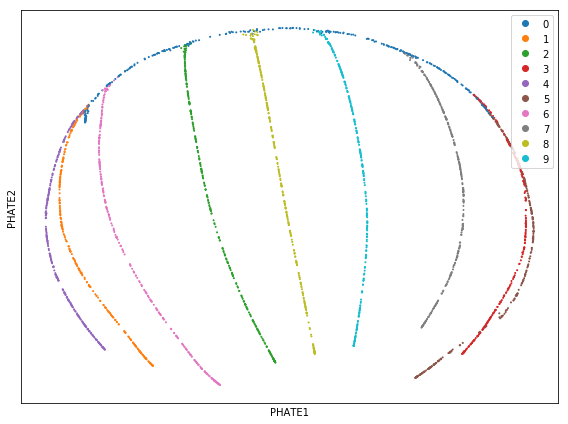

In [5]:
phate.plot.scatter2d(tree_phate, c=branches, figsize=(8,6))

Good news! Our branches separate nicely. However, all of the interesting activity seems to be concentrated into one region of the plot - in this case we should try the square root potential instead with `gamma=0`. We can also try increasing `t` to make the structure a little clearer - in this case, because synthetic data in unusually structured, we can use a very large value, like 120, but in biological data the automatic `t` selection is generally very close to ideal. Note here that if we change these settings with `set_params`, we won't have to recompute the diffusion operator.

In [6]:
phate_operator.set_params(gamma=0, t=120)
tree_phate_sqrt = phate_operator.fit_transform(tree)

Calculating PHATE...
Using precomputed graph and diffusion operator...
Calculating diffusion potential...
Calculated diffusion potential in 1.21 seconds.
Calculating metric MDS...
Calculated metric MDS in 14.48 seconds.
Calculated PHATE in 15.71 seconds.


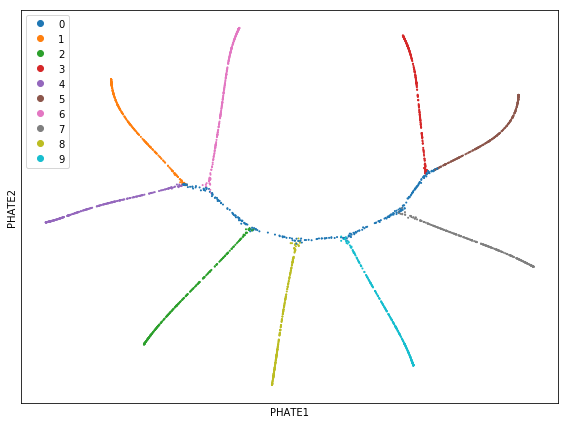

In [7]:
phate.plot.scatter2d(tree_phate_sqrt, c=branches, figsize=(8,6))

That looks much better! We can now see each of the branches clearly. We can also visualize the embedding in 3D.

Calculating metric MDS...
Calculated metric MDS in 35.26 seconds.


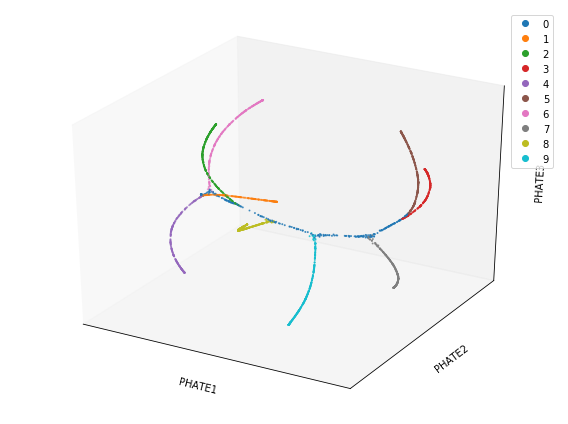

In [8]:
# pass the phate operator to avoid recomputing in 3D
# alternatively:
# >>> phate_operator.set_params(n_components=3)
# >>> tree_phate_sqrt = phate_operator.transform()
# >>> phate.plot.scatter3d(tree_phate_sqrt, c=branches, figsize=(8,6))
phate.plot.scatter3d(phate_operator, c=branches, figsize=(8,6))

We can even create a gif showing the rotating 3D plot.

In [9]:
phate.plot.rotate_scatter3d(phate_operator, c=branches, figsize=(8,6))
# to save as a gif:
# >>> phate.plot.rotate_scatter3d(phate_operator, c=branches, figsize=(8,6), filename="phate.gif")
# to save as an mp4:
# >>> phate.plot.rotate_scatter3d(phate_operator, c=branches, figsize=(8,6), filename="phate.mp4")

Animation.save using <class 'matplotlib.animation.HTMLWriter'>


## Comparison with other visualization tools

In this section we will compare PHATE to other common visualization tools on this dataset.

* PCA
* MDS
* t-SNE

_Warning: MDS is slow. This may take a while._

In [10]:
import sklearn.decomposition # PCA
import sklearn.manifold # MDS, t-SNE
import time

start = time.time()
pca_operator = sklearn.decomposition.PCA(n_components=2)
tree_pca = pca_operator.fit_transform(tree)
end = time.time()
print("Embedded PCA in {:.2f} seconds.".format(end-start))

start = time.time()
mds_operator = sklearn.manifold.MDS(n_components=2, metric=True, n_jobs=-2)
tree_mds = mds_operator.fit_transform(tree)
end = time.time()
print("Embedded MDS in {:.2f} seconds.".format(end-start))

start = time.time()
tsne_operator = sklearn.manifold.TSNE(n_components=2)
tree_tsne = tsne_operator.fit_transform(tree)
end = time.time()
print("Embedded t-SNE in {:.2f} seconds.".format(end-start))

Embedded PCA in 0.05 seconds.
Embedded MDS in 187.77 seconds.
Embedded t-SNE in 59.77 seconds.


PCA is a lot faster than all manifold methods (PHATE, MDS and t-SNE.) However, among the manifold methods, PHATE is competitive (we ran it on 1.3 million cells in just over three hours!) You will also see below, for trajectory-based data, PHATE gives the clearest representation of the data.

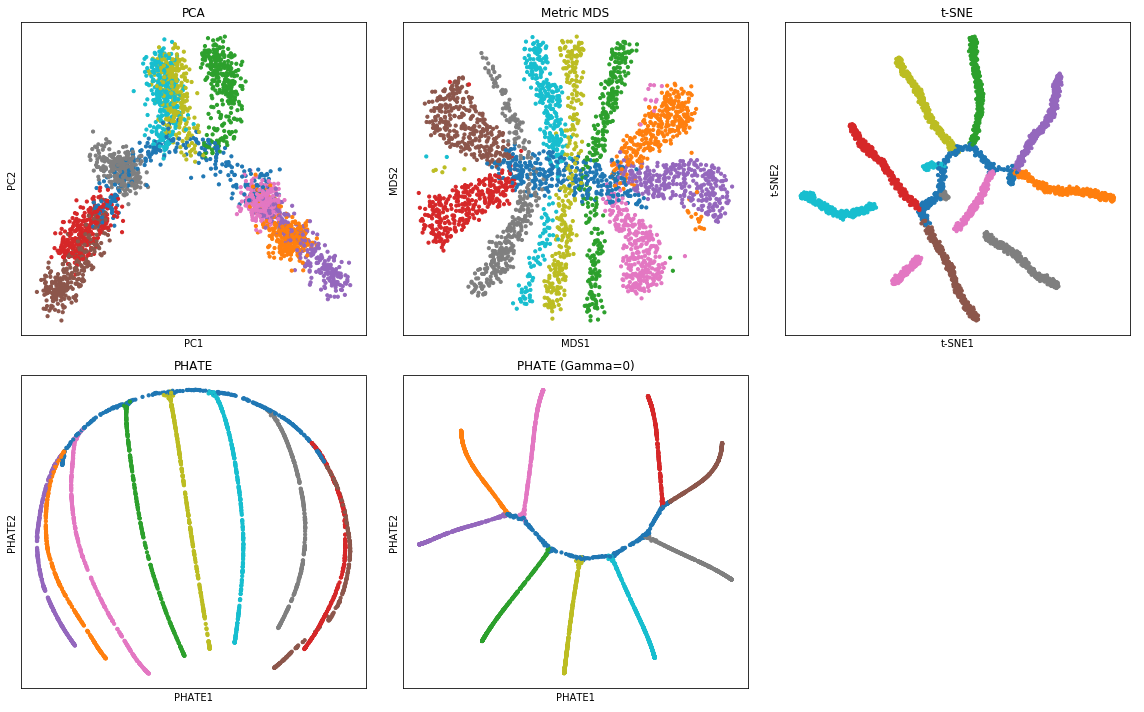

In [11]:
# plot everything
import matplotlib.pyplot as plt
f, axes = plt.subplots(2,3, figsize=(16,10))
ax1, ax2, ax3, ax4, ax5, ax6 = axes.ravel()

#plotting PCA
phate.plot.scatter2d(tree_pca, label_prefix="PC", s=10, 
                     c=branches, title="PCA", 
                     legend=False, ax=ax1)

#plotting metric MDS
phate.plot.scatter2d(tree_mds, label_prefix="MDS", s=10, 
                     c=branches, title="Metric MDS", 
                     legend=False, ax=ax2)

#plotting tSNE
phate.plot.scatter2d(tree_tsne, label_prefix="t-SNE", s=10, 
                     c=branches, title="t-SNE", 
                     legend=False, ax=ax3)

#plotting PHATE
phate.plot.scatter2d(tree_phate, label_prefix="PHATE", s=10, 
                     c=branches, title="PHATE", 
                     legend=False, ax=ax4)

#plotting PHATE - square root potential
phate.plot.scatter2d(tree_phate_sqrt, label_prefix="PHATE", s=10, 
                     c=branches, title="PHATE (Gamma=0)", 
                     legend=False, ax=ax5)

ax6.set_axis_off() #hide unused axis

plt.tight_layout()
plt.show()